### Import libraries

In [1]:
import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing import image, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore")


### Problem Analysis
- Objective: Classify images into Cat (0) or Dog (1).

- Task type: Binary Image Classification.

- Dataset: 24,998 images (12,499 cats, 12,499 dogs). [Bhavik Jikadara — Cat & Dog Classification Dataset](https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset)  

- Train set: Labeled (with annotations).

- Test set: Unlabeled → used to evaluate the model.

- Final output: A model that takes an image as input and predicts either "Cat" or "Dog".

### Download dataset with kagglehub

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


### Check dataset structure

In [3]:
dataset_path = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"

cat_dir = os.path.join(dataset_path, "Cat")
dog_dir = os.path.join(dataset_path, "Dog")
num_cats = len(os.listdir(cat_dir))
num_dogs = len(os.listdir(dog_dir))

print(f"Number of cat images: {num_cats}")
print(f"Number of dog images: {num_dogs}")

Number of cat images: 12499
Number of dog images: 12499


### Visualize sample images (EDA)

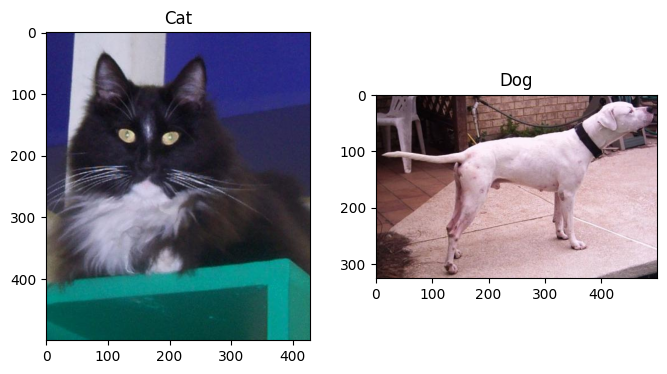

In [4]:
sample_cat = random.choice(os.listdir(os.path.join(dataset_path, "Cat")))
sample_dog = random.choice(os.listdir(os.path.join(dataset_path, "Dog")))

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(Image.open(os.path.join(dataset_path, "Cat", sample_cat)))
ax[0].set_title("Cat")
ax[1].imshow(Image.open(os.path.join(dataset_path, "Dog", sample_dog)))
ax[1].set_title("Dog")
plt.show()

### Preprocessing
- Đoạn code dưới dùng ImageDataGenerator để chuẩn bị dữ liệu huấn luyện và kiểm định cho mô hình.
- Hàm resize_with_padding() giúp đưa ảnh về kích thước 224×224 mà vẫn giữ tỷ lệ, đồng thời chuẩn hóa giá trị điểm ảnh về [0,1].

- Tập huấn luyện được áp dụng các kỹ thuật tăng cường dữ liệu như xoay, phóng to, lật ngang… để giảm overfitting.
Tập kiểm định chỉ được resize và chuẩn hóa, không tăng cường.

- Hai generator:

  - train_gen: sinh dữ liệu huấn luyện (có tăng cường).

  - val_gen: sinh dữ liệu kiểm định (không tăng cường).

- Mục tiêu là giúp mô hình học tốt hơn và tổng quát hóa tốt hơn trên dữ liệu mới.

In [5]:
img_size = (224, 224)
batch_size = 32


def resize_with_padding(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize_with_pad(img, target_height=224, target_width=224)
    img = img / 255.0
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=resize_with_padding,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


val_datagen = ImageDataGenerator(
    preprocessing_function=resize_with_padding,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)


val_gen = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=False
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### Binary Classification Model using MobileNetV2 (Transfer Learning)

In [6]:
input_shape = (224, 224, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train the model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_mn = ModelCheckpoint('best_mn.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [8]:
# Train MobileNetV2
history_mn = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint_mn, reduce_lr]
)



Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9467 - loss: 0.1351
Epoch 1: val_accuracy improved from -inf to 0.98419, saving model to best_mn.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 609s 946ms/step - accuracy: 0.9467 - loss: 0.1351 - val_accuracy: 0.9842 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9696 - loss: 0.0755
Epoch 2: val_accuracy did not improve from 0.98419
625/625 ━━━━━━━━━━━━━━━━━━━━ 446s 713ms/step - accuracy: 0.9696 - loss: 0.0755 - val_accuracy: 0.9838 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9728 - loss: 0.0706
Epoch 3: val_accuracy did not improve from 0.98419
625/625 ━━━━━━━━━━━━━━━━━━━━ 445s 713ms/step - accuracy: 0.9728 - loss: 0.0706 - val_accuracy: 0.9838 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9732 - loss: 0.0676
Epoch 4: val_accuracy did no

#### Epoch 5 is the best

### Evaluate the model

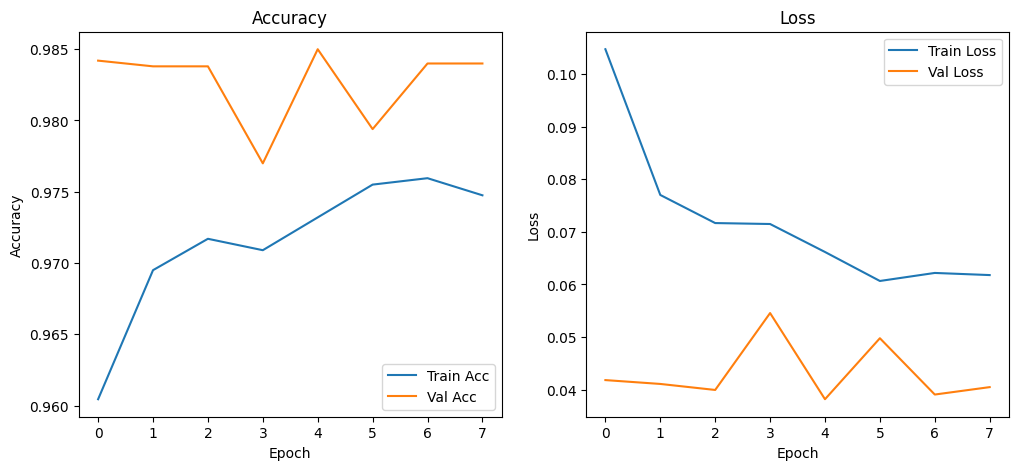

In [9]:
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(history_mn.history["accuracy"], label="Train Acc")
plt.plot(history_mn.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_mn.history["loss"], label="Train Loss")
plt.plot(history_mn.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()



###Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 371ms/step


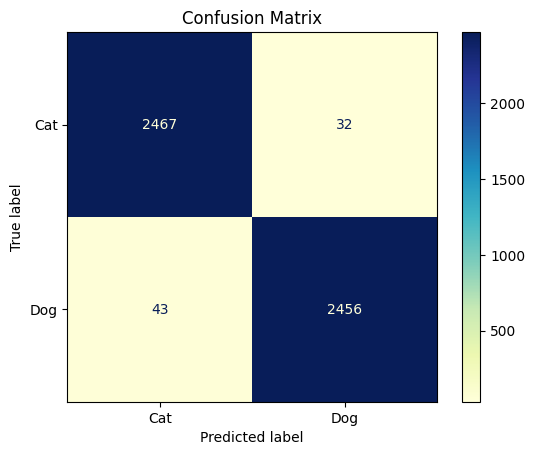

Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.99      0.99      2499
         Dog       0.99      0.98      0.98      2499

    accuracy                           0.98      4998
   macro avg       0.99      0.98      0.98      4998
weighted avg       0.99      0.98      0.98      4998



In [10]:
best_model = load_model("/content/best_mn.keras")

val_gen.reset()

y_true = val_gen.classes

y_pred = best_model.predict(val_gen, verbose=1)

if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))
disp.plot(cmap="YlGnBu", values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))


### Predict new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Ảnh này được dự đoán là: Dog (prob = 0.9626)


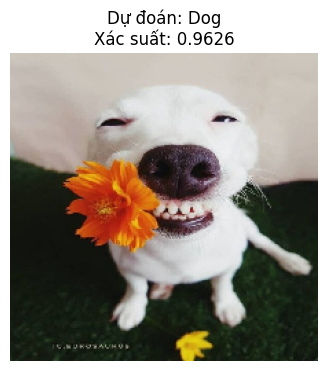

In [13]:
img_path = "/content/ChoCuoiBong.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = best_model.predict(img_array)
if pred.shape[1] == 1:
    class_idx = int(pred > 0.5)
    prob = float(pred)

class_name = list(val_gen.class_indices.keys())[class_idx]
print(f"Ảnh này được dự đoán là: {class_name} (prob = {prob:.4f})")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"Dự đoán: {class_name}\nXác suất: {prob:.4f}", fontsize=12)
plt.show()


### Fine-Tuning the MobileNetV2 Model

In [12]:
fine_tune_at = 100
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_ft = ModelCheckpoint('best_mn_finetune.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint_ft, reduce_lr]
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9252 - loss: 0.1869
Epoch 1: val_accuracy improved from -inf to 0.98539, saving model to best_mn_finetune.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 512s 782ms/step - accuracy: 0.9252 - loss: 0.1868 - val_accuracy: 0.9854 - val_loss: 0.0389 - learning_rate: 1.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9655 - loss: 0.0871
Epoch 2: val_accuracy improved from 0.98539 to 0.98599, saving model to best_mn_finetune.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 479s 766ms/step - accuracy: 0.9655 - loss: 0.0871 - val_accuracy: 0.9860 - val_loss: 0.0378 - learning_rate: 1.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9721 - loss: 0.0745
Epoch 3: val_accuracy improved from 0.98599 to 0.98619, saving model to best_mn_finetune.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 477s 763ms/step - accuracy: 0.9721 - loss: 0.0745 - val_accuracy: 0.9862 - val_loss: 0.0369 - learning_rate: 1.0000e-05
Epoch 4

#### Epoch 8 is the best

### Evaluate the model Fine-Tuning

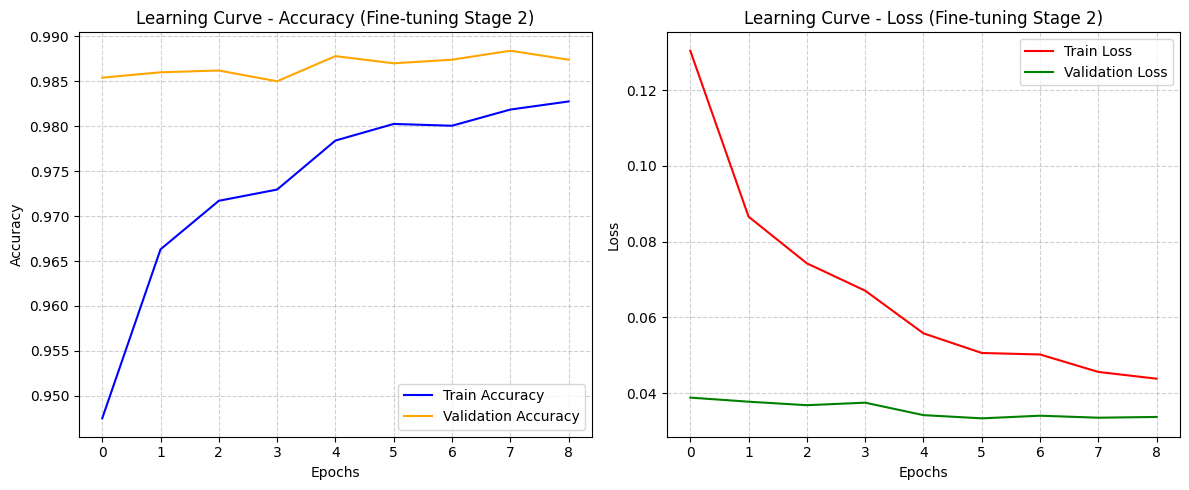

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_stage2.history["accuracy"], label="Train Accuracy", color='blue')
plt.plot(history_stage2.history["val_accuracy"], label="Validation Accuracy", color='orange')
plt.title("Learning Curve - Accuracy (Fine-tuning Stage 2)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,2,2)
plt.plot(history_stage2.history["loss"], label="Train Loss", color='red')
plt.plot(history_stage2.history["val_loss"], label="Validation Loss", color='green')
plt.title("Learning Curve - Loss (Fine-tuning Stage 2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Confusion Matrix Fine-Tuning

157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step


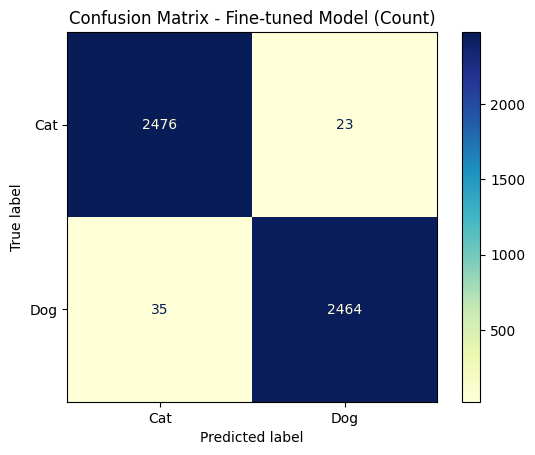

Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      2499
         Dog       0.99      0.99      0.99      2499

    accuracy                           0.99      4998
   macro avg       0.99      0.99      0.99      4998
weighted avg       0.99      0.99      0.99      4998



In [16]:
best_ft_model = load_model("/content/best_mn_finetune.keras")

val_gen.reset()

y_true = val_gen.classes
y_pred = best_ft_model.predict(val_gen, verbose=1)

if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()


cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(val_gen.class_indices.keys()))
disp.plot(cmap="YlGnBu", values_format="d")
plt.title("Confusion Matrix - Fine-tuned Model (Count)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))


### Predict new images Fine-Tuning

Class indices mapping (name -> index): {'Cat': 0, 'Dog': 1}
Class names ordered by index: ['Cat', 'Dog']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Raw prediction for /content/ChoCuoiBong.jpg: [[0.9837864]]
  Cat: 1.6214%
  Dog: 98.3786%


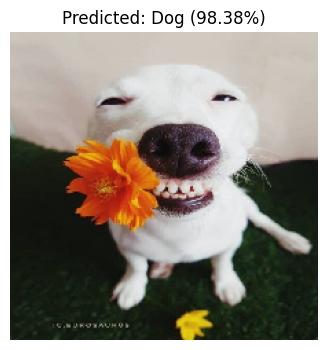

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Raw prediction for /content/MeoCamBong.jpg: [[1.0633155e-05]]
  Cat: 99.9989%
  Dog: 0.0011%


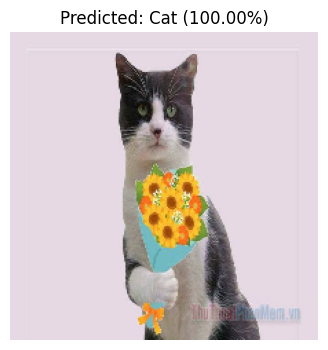

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Raw prediction for /content/MeoThiet.jpg: [[0.00158296]]
  Cat: 99.8417%
  Dog: 0.1583%


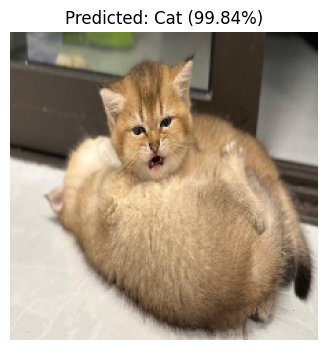

In [22]:

image_paths = [
    "/content/ChoCuoiBong.jpg",
    "/content/MeoCamBong.jpg",
    "/content/MeoThiet.jpg"
]


class_indices = val_gen.class_indices
class_names_by_index = [name for name, idx in sorted(class_indices.items(), key=lambda x: x[1])]
print("Class indices mapping (name -> index):", class_indices)
print("Class names ordered by index:", class_names_by_index)

def predict_and_show(img_path):
    img_display = image.load_img(img_path, target_size=(224,224))

    x = image.img_to_array(img_display)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    pred = best_ft_model.predict(x)
    print(f"\nRaw prediction for {img_path}: {pred}")
    if pred.ndim == 2 and pred.shape[1] == 1:
        prob_pos = float(pred[0][0])               # P(class_index = 1)
        prob_neg = 1.0 - prob_pos                  # P(class_index = 0)
        probs = [prob_neg, prob_pos]
        pred_index = int(prob_pos > 0.5)

    class_name = class_names_by_index[pred_index]

    for i, name in enumerate(class_names_by_index):
        print(f"  {name}: {probs[i]*100:.4f}%")

    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(img_path, target_size=(224,224)))
    plt.axis("off")
    plt.title(f"Predicted: {class_name} ({probs[pred_index]*100:.2f}%)")
    plt.show()

for p in image_paths:
    predict_and_show(p)
